In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [50]:
df = pd.read_csv('/content/drive/MyDrive/TaxiFare/train.csv', nrows=30000)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                30000 non-null  object 
 1   fare_amount        30000 non-null  float64
 2   pickup_datetime    30000 non-null  object 
 3   pickup_longitude   30000 non-null  float64
 4   pickup_latitude    30000 non-null  float64
 5   dropoff_longitude  30000 non-null  float64
 6   dropoff_latitude   30000 non-null  float64
 7   passenger_count    30000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 1.8+ MB


In [52]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,11.358652,-72.523370,39.939426,-72.518082,39.927691,1.665733
std,9.648585,10.366584,6.418488,10.380943,6.071009,1.285686
min,-3.000000,-75.414728,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992106,40.735010,-73.991189,40.734462,1.000000
50%,8.500000,-73.981739,40.752825,-73.980195,40.753574,1.000000
75%,12.500000,-73.967030,40.767446,-73.963704,40.768180,2.000000
max,200.000000,40.783472,401.083332,40.802437,43.415190,6.000000


In [53]:
df_location = df.loc[:, ['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                     'dropoff_latitude']]
df_location.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,4.5,-73.844311,40.721319,-73.841610,40.712278
1,16.9,-74.016048,40.711303,-73.979268,40.782004
2,5.7,-73.982738,40.761270,-73.991242,40.750562
3,7.7,-73.987130,40.733143,-73.991567,40.758092
4,5.3,-73.968095,40.768008,-73.956655,40.783762


In [54]:
df_location.isnull().sum()

fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
dtype: int64

In [55]:
def outlier_iqr(df, columns=None):
  if columns == None:
    columns = df.columns

  for col in columns:
    q1 = df[col].describe()['25%']
    q3 = df[col].describe()['75%']
    #四分位範囲
    iqr = q3 - q1

    outlier_min = q1 - iqr * 1.5
    outlier_max = q3 + iqr * 1.5

    df = df[(df[col] >= outlier_min) & (df[col] <= outlier_max)]
   
   
  return df 

In [56]:
df_location = outlier_iqr(df_location, columns=['fare_amount'])
df_location.shape

(27389, 5)

In [59]:
def calculation_distance(x_1, y_1, x_2, y_2):
    # 赤道半径 (km)
    R = 6371
    # Radian角に変換
    _x1, _y1, _x2, _y2  = map(np.radians, [x_1, y_1, x_2, y_2])
    
    delta_x = _x2 - _x1
    delta_y = _y2 - _y1
    
    # 距離を計算
    a = np.sin(delta_y/2.0)**2 + np.cos(_y1) * np.cos(_y2) * np.sin(delta_x/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

In [60]:
df_location['distance'] = calcuration_distance(df_location['pickup_longitude'],
                                              df_location['pickup_latitude'],
                                              df_location['dropoff_longitude'],
                                              df_location['dropoff_latitude'])
df_location.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,10960.083958
1,16.9,-74.016048,40.711303,-73.979268,40.782004,10953.445829
2,5.7,-73.982738,40.761270,-73.991242,40.750562,10951.384687
3,7.7,-73.987130,40.733143,-73.991567,40.758092,10953.674917
4,5.3,-73.968095,40.768008,-73.956655,40.783762,10946.943842


In [61]:
def calculation_azimuth(x_1, y_1, x_2, y_2):
    # Radian角に修正
    _x1, _y1, _x2, _y2 = map(np.radians, [x_1, y_1, x_2, y_2])
    
    delta_x = _x2 - _x1
    _y = np.sin(delta_x)
    _x = np.cos(_y1) * np.tan(_y2) - np.sin(_y1) * np.cos(delta_x)

    psi = np.rad2deg(np.arctan2(_y, _x))
    
    return np.where(psi < 0, 360 + psi, psi)

In [63]:
df_location['azimuth'] = calculation_azimuth(df_location['pickup_longitude'],
                                             df_location['pickup_latitude'],
                                             df_location['dropoff_longitude'],
                                             df_location['dropoff_latitude'])

df_location.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,azimuth
0,4.5,-73.844311,40.721319,-73.841610,40.712278,10960.083958,167.240469
1,16.9,-74.016048,40.711303,-73.979268,40.782004,10953.445829,21.498365
2,5.7,-73.982738,40.761270,-73.991242,40.750562,10951.384687,211.033211
3,7.7,-73.987130,40.733143,-73.991567,40.758092,10953.674917,352.327836
4,5.3,-73.968095,40.768008,-73.956655,40.783762,10946.943842,28.802783


In [64]:
# 方位にカテゴライズ
def direction(azimuth, n_ways=8):
    bins = np.linspace(0, 360, n_ways+1) 
    # 方位角に22.5°を足す。
    _azimuth = azimuth + 180/n_ways
    _azimuth = np.where(_azimuth >= 360, _azimuth - 360, _azimuth)
    return np.digitize(_azimuth, bins=bins) - 1

df_location['direction'] = direction(df_location['azimuth'])
df_location.head(10)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,azimuth,direction
0,4.5,-73.844311,40.721319,-73.841610,40.712278,10960.083958,167.240469,4
1,16.9,-74.016048,40.711303,-73.979268,40.782004,10953.445829,21.498365,0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,10951.384687,211.033211,5
3,7.7,-73.987130,40.733143,-73.991567,40.758092,10953.674917,352.327836,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,10946.943842,28.802783,1
5,12.1,-74.000964,40.731630,-73.972892,40.758233,10953.828231,38.631713,1
6,7.5,-73.980002,40.751662,-73.973802,40.764842,10950.865151,19.610063,0
7,16.5,-73.951300,40.774138,-73.990095,40.751048,10949.901196,231.852498,5
8,9.0,-74.006462,40.726713,-73.993078,40.731628,10957.332720,64.140893,1
9,8.9,-73.980658,40.733873,-73.991540,40.758138,10953.588727,341.237758,0


In [65]:
#位置情報を可視化
def plot_location(x, y, axis):
  plt.scatter(x, y, s=1.0,alpha=0.5)
  plt.axis(axis)

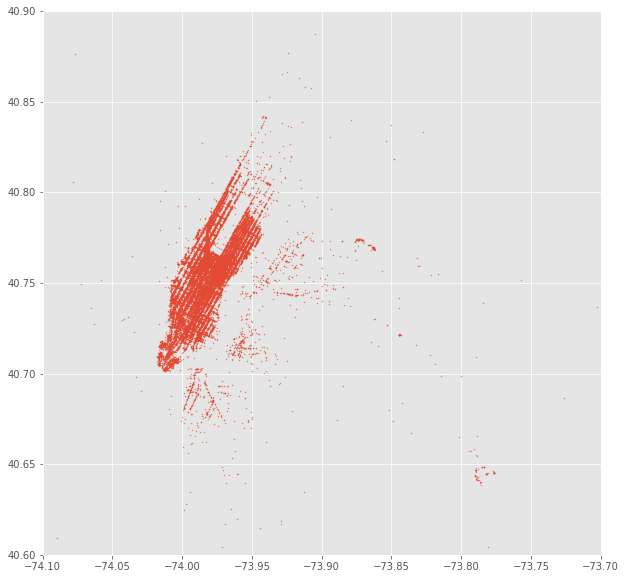

In [67]:
plt.figure(figsize=(10,10))
plot_location(df_location['pickup_longitude'],
              df_location['pickup_latitude'],
              axis=[-74.1,-73.7,40.6,40.9])

In [68]:
#データに合わせて点の色と大きさを変更
def plot_with_color(x, y, data, axis=None):
    plt.scatter(x, y, s=data, c=data, cmap=plt.get_cmap('jet'), alpha=0.3)
    plt.axis(axis)
    plt.colorbar()

    plt.xlabel('longitude', fontsize=15)
    plt.ylabel('latitude', fontsize=15)

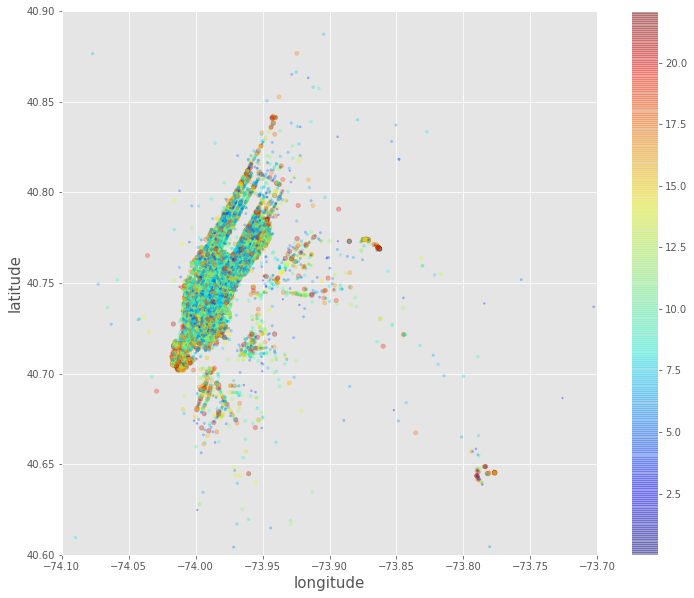

In [69]:
df_location = df_location[(df_location['fare_amount'] > 0) & (df_location['fare_amount'] <= 30)]

plt.figure(figsize=(12, 10))
plot_with_color(x=df_location['pickup_longitude'], 
                y=df_location['pickup_latitude'],
                data=df_location['fare_amount'],
                axis=[-74.1, -73.7, 40.6, 40.9])

# df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.3,
#         s=df['fare_amount'],figsize=(10, 8), xlim=(-74.1, -73.7), ylim=(40.6, 40.9),
#         c='fare_amount', cmap=plt.get_cmap('jet'))
